In [1]:
num2labels={0: 'healthy', 1: 'resp_illness_not_identified', 2: 'no_resp_illness_exposed', 3: 'recovered_full', 4: 'positive_mild', 5: 'positive_asymp', 6: 'positive_moderate'}
num2labels

{0: 'healthy',
 1: 'resp_illness_not_identified',
 2: 'no_resp_illness_exposed',
 3: 'recovered_full',
 4: 'positive_mild',
 5: 'positive_asymp',
 6: 'positive_moderate'}

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# dataset downloaded from https://github.com/iiscleap/Coswara-Data
class CoughingDataset(Dataset):
#rapper for the Cough dataset
    # Argument List
    #  path to the Cough csv file    
    def __init__(self, csv_path):
        csvData = pd.read_csv(csv_path)
        #initialize lists to hold file names, labels, and folder numbers
        self.labels = []
        self.file_path = []
        self.indexes = []
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)-1):
            self.file_path.append(csvData.iloc[i, -2])
            self.labels.append(csvData.iloc[i, 2]) 
            self.indexes.append(i)   
    def __getitem__(self, index):
        path = self.file_path[index]
        if type(path)==str:
            pass
        else:
            print(" ======= path:", path)            
        sound = torchaudio.load(path,out=None, normalization = True)
        soundData = sound[0]
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz)
        #downsample the audio to ~8kHz
        tempData = torch.zeros([160000]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 160000:
            tempData[:soundData.numel()] = soundData[0,:]
        else:
            tempData[:] = soundData[0,:160000]
        
        soundData = tempData
        soundFormatted = torch.zeros([32000])
        soundFormatted[:32000] = soundData[::5] # take every fifth sample of soundData
        soundFormatted=torch.unsqueeze(soundFormatted,0)
        return soundFormatted , self.labels[index]
    
    def __len__(self):
        return len(self.file_path)


csv_path = '/workspace/Coswara-Data/train.csv'
test_csv = '/workspace/Coswara-Data/test.csv'

train_set = CoughingDataset(csv_path)
test_set = CoughingDataset(test_csv)
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True, **kwargs)
train_iter=iter(train_loader)
test_iter=iter(test_loader)

Train set size: 1171
Test set size: 291


In [6]:
a,b=next(train_iter)
a.size(),b.size()

(torch.Size([128, 1, 32000]), torch.Size([128]))

In [ ]:
b

# Coughing model building 

 we will use a convolutional neural network to process the raw audio data. Usually more advanced transforms are applied to the audio data, however CNNs can be used to accurately process the raw data. The specific architecture is modeled after the M5 network architecture described in https://arxiv.org/pdf/1610.00087.pdf. An important aspect of models processing raw audio data is the receptive field of their first layer’s filters. Our model’s first filter is length 80 so when processing audio sampled at 8kHz the receptive field is around 10ms. This size is similar to speech processing applications that often use receptive fields ranging from 20ms to 40ms. model adapted from [ here](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/audio_classifier_tutorial.ipynb#scrollTo=zFcvJkVk-jhQ)
note: modified optimizer with NVIDIA **novogad**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np
class COVID(nn.Module):
    def __init__(self):
        super(COVID, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(30) #input should be 512x30 so this outputs a 512x1
        self.fc1 = nn.Linear(512, 7)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.permute(0, 2, 1) #change the 512x1 to 1x512
        x = self.fc1(x)
        return F.log_softmax(x, dim = 2)

model = COVID()
model.to(device)
print(model)

COVID(
  (conv1): Conv1d(1, 128, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (avgPool): AvgPool1d(kernel_size=(30,), stride=(30,)

In [8]:
from novograd import Novograd

In [9]:
optimizer = Novograd(model.parameters(), lr = 0.01, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

In [ ]:
#!export CUDA_VISIBLE_DEVICES=0

In [10]:
def train(model, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        data = data.requires_grad_() #set requires_grad to True for training
        output = model(data)
        output = output.permute(1, 0, 2) #original output dimensions are batchSizex1x10 
        loss = F.nll_loss(output[0], target) #the loss functions expects a batchSizex10 input        
        loss.backward()        
        optimizer.step()
        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))

In [11]:
def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
log_interval = 20
epochs = 5 
for epoch in range(1, epochs):
    if epoch == 1:
        print("First round of training complete. Setting learn rate to 0.001.")
    scheduler.step()
    train(model, epoch)
test(model, epoch)

First round of training complete. Setting learn rate to 0.001.


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Epoch: 1 [0/1171 (0%)]	Loss: 1.761742
Train Epoch: 2 [0/1171 (0%)]	Loss: 1.029395
Train Epoch: 3 [0/1171 (0%)]	Loss: 0.940315
Train Epoch: 4 [0/1171 (0%)]	Loss: 0.904858

Test set: Accuracy: 230/291 (79%)



In [13]:
PATH='./saved_model/convid.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

In [14]:
loaded_model = COVID()
loaded_model.to(device)
opt = Novograd(loaded_model.parameters(), lr = 0.01, weight_decay = 0.0001)
sch = optim.lr_scheduler.StepLR(opt, step_size = 20, gamma = 0.1)

checkpoint = torch.load(PATH)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loaded_model.eval()

COVID(
  (conv1): Conv1d(1, 128, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (avgPool): AvgPool1d(kernel_size=(30,), stride=(30,)

In [15]:
num2labels


{0: 'healthy',
 1: 'resp_illness_not_identified',
 2: 'no_resp_illness_exposed',
 3: 'recovered_full',
 4: 'positive_mild',
 5: 'positive_asymp',
 6: 'positive_moderate'}

In [16]:
# dataset downloaded from https://github.com/iiscleap/Coswara-Data
class On_the_fly_Coughing(Dataset):
#rapper for the Cough dataset
    # Argument List
    #  path to the Cough csv file    
    def __init__(self, csv_path , label_to_retrieve):
        csvData = pd.read_csv(csv_path)
        #initialize lists to hold file names, labels, and folder numbers
        self.labels = []
        self.file_path = []
        self.indexes = []
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i,2] in label_to_retrieve:
                self.file_path.append(csvData.iloc[i, -2])
                self.labels.append(csvData.iloc[i, 2]) 
                self.indexes.append(i)   
    def __getitem__(self, index):
        path = self.file_path[index]
        print("wav file location " , path)
        print("label ", num2labels[self.labels[index]])
        #sound = torchaudio.load(path, out = None, normalization = True)
        sound = torchaudio.load(path, out = None, normalization = True)
        soundData = sound[0]
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)
        #downsample the audio to ~8kHz
        tempData = torch.zeros([160000]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 160000:
            tempData[:soundData.numel()] = soundData[0,:]
        else:
            tempData[:] = soundData[0,:160000]
        
        soundData = tempData
        soundFormatted = torch.zeros([32000])
        soundFormatted[:32000] = soundData[::5] #take every fifth sample of soundData
        soundFormatted=torch.unsqueeze(soundFormatted,0)
        return path, soundFormatted , self.labels[index]
    
    def __len__(self):
        return len(self.file_path)

    
csv_path = 'test.csv'

positive_with_covid=On_the_fly_Coughing(csv_path,[3,4,6] )
healthy=On_the_fly_Coughing(csv_path,[0])
asymptomatic = On_the_fly_Coughing(csv_path,[5])
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
asymptomatic_loader = torch.utils.data.DataLoader(asymptomatic, batch_size = 1, shuffle = True, **kwargs)
covid_excl_asy_loader = torch.utils.data.DataLoader(positive_with_covid, batch_size = 1, shuffle = True, **kwargs)
healthy_loader = torch.utils.data.DataLoader(healthy, batch_size = 1, shuffle = True, **kwargs)


In [25]:
asyn_wav_loc, asyn_in_data, asyn_lb= iter(asymptomatic_loader).next()
covid_pos_wav_loc, covid_pos_in_data, covid_lb= iter(covid_excl_asy_loader).next()
healthy_wav_loc, healthy_pos_in_data, healthy_lb= iter(healthy_loader).next()

print(asyn_wav_loc[0], asyn_lb)
print(covid_pos_wav_loc[0], covid_lb)
print(healthy_wav_loc[0], healthy_lb)


wav file location  /workspace/covid/data/20200820/40NRJEGpU9Vg2IFXcuqCQLiKLVz1/cough-heavy.wav
label  positive_asymp
wav file location  /workspace/covid/data/20201012/L9QbDvX4UtMhFOsYuh2aamY3VK23/cough-heavy.wav
label  positive_mild
wav file location  /workspace/covid/data/20200415/0KOy96zEUfdMY4rZzwrDT0gMPDa2/cough-heavy.wav
label  healthy
/workspace/covid/data/20200820/40NRJEGpU9Vg2IFXcuqCQLiKLVz1/cough-heavy.wav tensor([5])
/workspace/covid/data/20201012/L9QbDvX4UtMhFOsYuh2aamY3VK23/cough-heavy.wav tensor([4])
/workspace/covid/data/20200415/0KOy96zEUfdMY4rZzwrDT0gMPDa2/cough-heavy.wav tensor([0])


In [27]:
import IPython.display as ipd
def listen2audio(wav_loc, lb):
    audio_sample=wav_loc[0]
    print("originally labelled by expert as {}".format(num2labels[lb.item()])  )
    return ipd.Audio(audio_sample) # load a local WAV file
listen2audio(asyn_wav_loc, asyn_lb)
#listen2audio(covid_pos_wav_loc, covid_lb)
#listen2audio(healthy_wav_loc, healthy_lb)

originally labelled by expert as positive_asymp


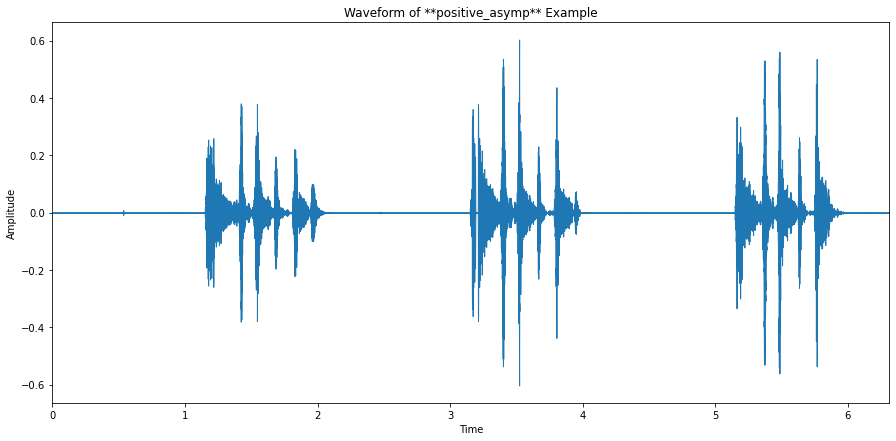

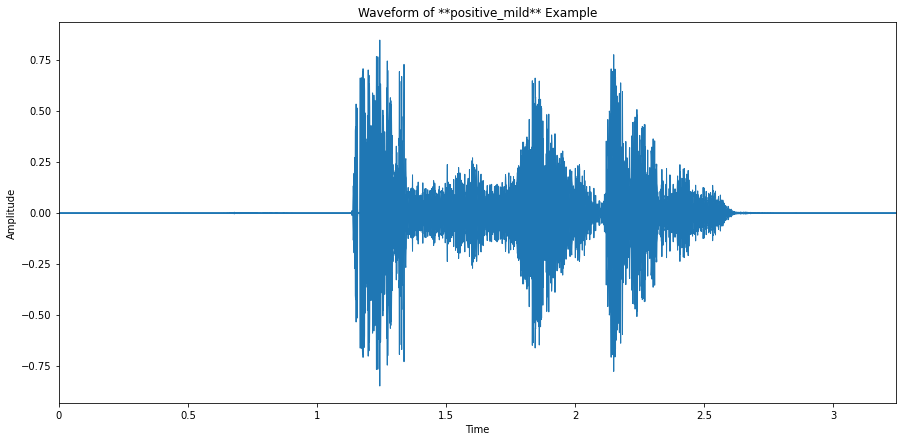

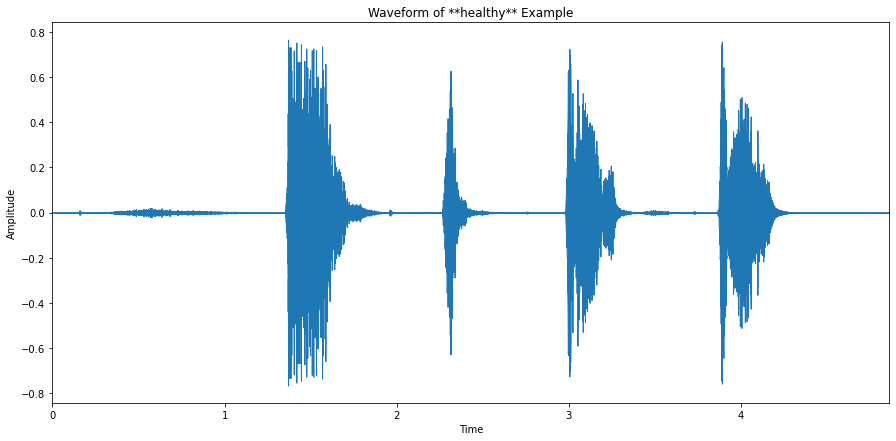

In [28]:
import matplotlib.pyplot as plt
from librosa.display import waveplot
import librosa
import IPython.display as ipd
%matplotlib inline
def visualize_waveform(wav_loc, lb):
    # Load and listen to the audio file
    example_file = wav_loc[0]
    audio, sample_rate = librosa.load(example_file)

    #ipd.Audio(example_file, rate=sample_rate)
    # Plot our example audio file's waveform
    plt.rcParams['figure.figsize'] = (15,7)
    plt.title('Waveform of **{}** Example'.format(num2labels[lb.item()]))
    plt.ylabel('Amplitude')

    waveplot(audio)
    plt.show()
    return audio

asyn_audio=visualize_waveform(asyn_wav_loc, asyn_lb)
covid_audio=visualize_waveform(covid_pos_wav_loc, covid_lb)
healthy_audio=visualize_waveform(healthy_wav_loc, healthy_lb)

/opt/conda/lib/python3.6/site-packages/librosa/display.py:831: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.6/site-packages/librosa/display.py:831: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.6/site-packages/librosa/display.py:831: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


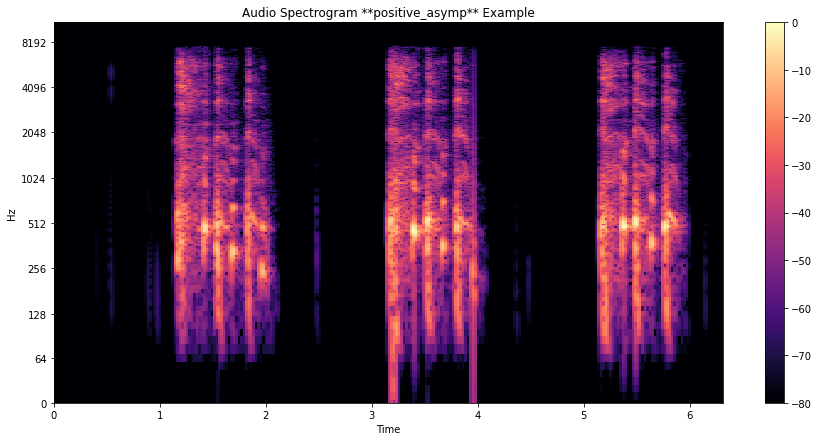

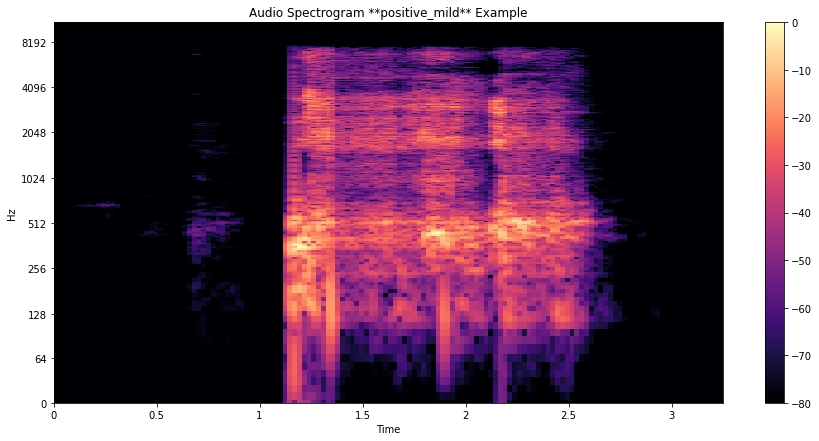

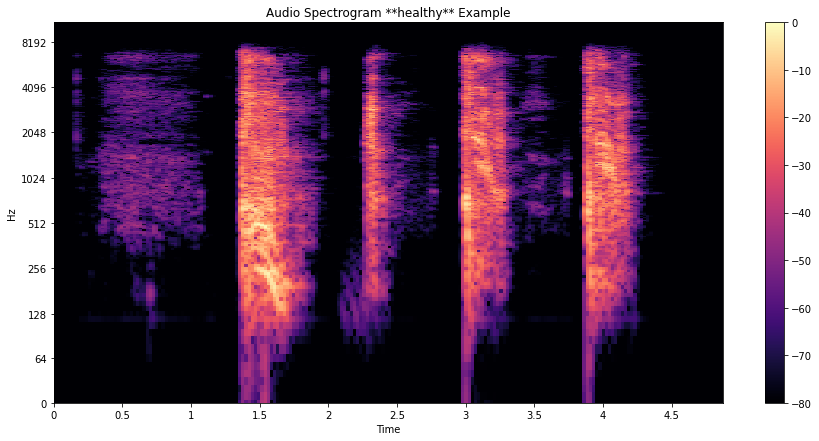

In [29]:
import numpy as np
def visualize_spectrogram(audio, lb):
    # Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
    spec = np.abs(librosa.stft(audio))
    spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

    # Use log scale to view frequencies
    librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
    plt.colorbar()
    plt.title('Audio Spectrogram **{}** Example'.format(num2labels[lb.item()]))
    plt.show()
visualize_spectrogram(asyn_audio, asyn_lb)
visualize_spectrogram(covid_audio, covid_lb)
visualize_spectrogram(healthy_audio, healthy_lb)

In [30]:

def get_on_the_fly_prediction(input_data, loaded_model,lb):
    out= loaded_model(input_data)
    out = out.permute(1, 0, 2)
    pred = out.max(2)[1].item()
    assert type(pred)==int
    return num2labels[pred]
pred=get_on_the_fly_prediction(healthy_pos_in_data.cuda(), loaded_model,healthy_lb )
print("prediction", pred, "| true label ", num2labels[healthy_lb.item()])
pred=get_on_the_fly_prediction(asyn_in_data.cuda(), loaded_model, asyn_lb )
print("prediction", pred , "| true label ", num2labels[asyn_lb.item()])
pred=get_on_the_fly_prediction(covid_pos_in_data.cuda(),loaded_model, covid_lb)
print("prediction", pred, "| true label " , num2labels[covid_lb.item()])

prediction healthy | true label  healthy
prediction healthy | true label  positive_asymp
prediction healthy | true label  positive_mild


In [31]:
import torch
import torchvision 
input_names = [ "input" ] + [ "learned_%d" % i for i in range(30) ]
output_names = [ "output" ]

torch.onnx.export(loaded_model, asyn_in_data.cuda(), "./saved_model/covid.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%input : Float(1:32000, 1:32000, 32000:1),
      %learned_0 : Float(128:80, 1:80, 80:1),
      %learned_1 : Float(128:1),
      %learned_2 : Float(128:1),
      %learned_3 : Float(128:1),
      %learned_4 : Float(128:1),
      %learned_5 : Float(128:1),
      %learned_7 : Float(128:384, 128:3, 3:1),
      %learned_8 : Float(128:1),
      %learned_9 : Float(128:1),
      %learned_10 : Float(128:1),
      %learned_11 : Float(128:1),
      %learned_12 : Float(128:1),
      %learned_14 : Float(256:384, 128:3, 3:1),
      %learned_15 : Float(256:1),
      %learned_16 : Float(256:1),
      %learned_17 : Float(256:1),
      %learned_18 : Float(256:1),
      %learned_19 : Float(256:1),
      %learned_21 : Float(512:768, 256:3, 3:1),
      %learned_22 : Float(512:1),
      %learned_23 : Float(512:1),
      %learned_24 : Float(512:1),
      %learned_25 : Float(512:1),
      %learned_26 : Float(512:1),
      %learned_29 : Float(7:1),
      %54 : Float(512:1, 7:512)):
  %31 : Float(1:1021568